# WIP Data augmentation 


In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub


import pathlib
import pandas as pd

import pydicom # for DICOM images
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
print(tf.__version__)

2.6.0


In [2]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [3]:
# Directory
directory = '/Users/renau/Desktop/DATA/data_proj_melanoma'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

# Change columns names
new_names = ['dcm_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

Train has 33,126 rows and Test has 10,982 rows.


In [4]:
# === JPEG ===
# Create the paths
path_train = directory + '/jpeg/train/' + train_df['dcm_name'] + '.jpg'
path_test = directory + '/jpeg/test/' + test_df['dcm_name'] + '.jpg'

# Append to the original dataframes
train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test

In [5]:
malignant_df = train_df[train_df['target'] == 1]
malignant_df.head()

,dcm_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,path_jpeg
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...


In [6]:
benin_df = train_df[train_df['target'] == 0]
benin_df.head()

,dcm_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,path_jpeg
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...


In [7]:
mal_file = malignant_df['path_jpeg'].values
mal_labels = malignant_df['target'].values
mal_train_ds = tf.data.Dataset.from_tensor_slices((mal_file, mal_labels))
len(list(mal_train_ds))

584

In [8]:
ben_file = benin_df['path_jpeg'].values
ben_labels = benin_df['target'].values
ben_train_ds = tf.data.Dataset.from_tensor_slices((ben_file, ben_labels))
len(list(ben_train_ds))

32542

In [9]:
ben_train_ds = ben_train_ds.shuffle(len(list(ben_train_ds)))
len(list(ben_train_ds))

32542

In [10]:
def make_balanced_dataset(ds_class1, ds_class2):
    half_size = min(len(list(ds_class1)),len(list(ds_class2)))
    ds_1 = ds_class1.take(half_size)
    ds_2 = ds_class2.take(half_size)
    ds_full = ds_1.concatenate(ds_2)
    ds_full = ds_full.shuffle(half_size*2, reshuffle_each_iteration=False)
    return ds_full.skip((half_size*2)//5),ds_full.take((half_size*2)//5),
#print(make_balanced_dataset(ben_train_ds,mal_train_ds))   
ds_train, ds_val = make_balanced_dataset(ben_train_ds,mal_train_ds)
size = len(list(ds_val))
print(size, len(list(ds_train)))

233 935


In [11]:
ex_ds = ds_train.take(4)
for element in ex_ds :
    print(element[0].numpy(),'and target: ',element[1].numpy())

b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_6257422.jpg' and target:  0
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_0599605.jpg' and target:  1
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_0272026.jpg' and target:  0
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_2937642.jpg' and target:  1


In [12]:
def read_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, dtype = tf.uint8, expand_animations = False)
    return image, label

ds_train = ds_train.map(read_image)
ds_val = ds_val.map(read_image)

In [13]:
ex_ds = ds_train.take(3)
for element in ex_ds :
    print(element[0].numpy().shape)

(480, 640, 3)
(2448, 3264, 3)
(4000, 6000, 3)


In [14]:
def adapt_data(image, label):
    image = tf.image.resize(image, [256,256])
    return image, label

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float64)
    return image, label
    
ds_train= ds_train.map(adapt_data).map(convert_to_float).batch(16)
ds_val= ds_val.map(adapt_data).map(convert_to_float).batch(16)

ex_ds = ds_train.take(3)
for element in ex_ds :
    print(element[0].shape)
    print(element[1].shape)

(16, 256, 256, 3)
(16,)
(16, 256, 256, 3)
(16,)
(16, 256, 256, 3)
(16,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

model = tf.keras.Sequential([ 
    
# == Input == 
    
    layers.InputLayer(
    input_shape=(256,256,3)),
    
# == Data Augmentation ==
    
    preprocessing.RandomContrast(factor=0.1),
    preprocessing.RandomFlip(mode='horizontal'), 
    preprocessing.RandomFlip(mode='vertical'), 
    preprocessing.RandomRotation(factor=0.20),

# == CONV == 
    
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

# == HEAD ==
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(1,activation='sigmoid')
])

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast (RandomContr (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      8

In [18]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=500,
)

Epoch 1/500
59/59 [==============================] - 17s 136ms/step - loss: 0.7377 - binary_accuracy: 0.6096 - val_loss: 0.7204 - val_binary_accuracy: 0.5279
Epoch 2/500
59/59 [==============================] - 2s 34ms/step - loss: 0.6597 - binary_accuracy: 0.6599 - val_loss: 0.6440 - val_binary_accuracy: 0.6009
Epoch 3/500
59/59 [==============================] - 2s 33ms/step - loss: 0.6286 - binary_accuracy: 0.6663 - val_loss: 0.6381 - val_binary_accuracy: 0.6352
Epoch 4/500
59/59 [==============================] - 2s 33ms/step - loss: 0.6337 - binary_accuracy: 0.6727 - val_loss: 0.5819 - val_binary_accuracy: 0.6652
Epoch 5/500
59/59 [==============================] - 2s 32ms/step - loss: 0.6349 - binary_accuracy: 0.6599 - val_loss: 0.5490 - val_binary_accuracy: 0.7124
Epoch 6/500
59/59 [==============================] - 2s 33ms/step - loss: 0.6145 - binary_accuracy: 0.6791 - val_loss: 0.5312 - val_binary_accuracy: 0.7339
Epoch 7/500
59/59 [==============================] - 2s 32ms/s

59/59 [==============================] - 2s 32ms/step - loss: 0.4665 - binary_accuracy: 0.7519 - val_loss: 0.4874 - val_binary_accuracy: 0.7897
Epoch 54/500
59/59 [==============================] - 2s 32ms/step - loss: 0.4633 - binary_accuracy: 0.7711 - val_loss: 0.4943 - val_binary_accuracy: 0.7854
Epoch 55/500
59/59 [==============================] - 2s 31ms/step - loss: 0.4537 - binary_accuracy: 0.7818 - val_loss: 0.4687 - val_binary_accuracy: 0.7897
Epoch 56/500
59/59 [==============================] - 2s 31ms/step - loss: 0.4632 - binary_accuracy: 0.7775 - val_loss: 0.4839 - val_binary_accuracy: 0.7682
Epoch 57/500
59/59 [==============================] - 2s 32ms/step - loss: 0.4647 - binary_accuracy: 0.7754 - val_loss: 0.4946 - val_binary_accuracy: 0.7682
Epoch 58/500
59/59 [==============================] - 2s 32ms/step - loss: 0.4534 - binary_accuracy: 0.7711 - val_loss: 0.4909 - val_binary_accuracy: 0.7511
Epoch 59/500
59/59 [==============================] - 2s 32ms/step - lo

59/59 [==============================] - 2s 32ms/step - loss: 0.3787 - binary_accuracy: 0.8278 - val_loss: 0.5189 - val_binary_accuracy: 0.7811
Epoch 106/500
59/59 [==============================] - 2s 32ms/step - loss: 0.3798 - binary_accuracy: 0.8257 - val_loss: 0.5533 - val_binary_accuracy: 0.7597
Epoch 107/500
59/59 [==============================] - 2s 31ms/step - loss: 0.3684 - binary_accuracy: 0.8449 - val_loss: 0.5414 - val_binary_accuracy: 0.7639
Epoch 108/500
59/59 [==============================] - 2s 31ms/step - loss: 0.3693 - binary_accuracy: 0.8310 - val_loss: 0.5321 - val_binary_accuracy: 0.7682
Epoch 109/500
59/59 [==============================] - 2s 31ms/step - loss: 0.3918 - binary_accuracy: 0.8214 - val_loss: 0.5406 - val_binary_accuracy: 0.7725
Epoch 110/500
59/59 [==============================] - 2s 32ms/step - loss: 0.3755 - binary_accuracy: 0.8160 - val_loss: 0.5443 - val_binary_accuracy: 0.7597
Epoch 111/500
59/59 [==============================] - 2s 31ms/ste

Epoch 157/500
59/59 [==============================] - 2s 31ms/step - loss: 0.3078 - binary_accuracy: 0.8674 - val_loss: 0.6820 - val_binary_accuracy: 0.7468
Epoch 158/500
59/59 [==============================] - 2s 31ms/step - loss: 0.3266 - binary_accuracy: 0.8663 - val_loss: 0.5839 - val_binary_accuracy: 0.7639
Epoch 159/500
59/59 [==============================] - 2s 31ms/step - loss: 0.3092 - binary_accuracy: 0.8567 - val_loss: 0.6295 - val_binary_accuracy: 0.7554
Epoch 160/500
59/59 [==============================] - 2s 31ms/step - loss: 0.2911 - binary_accuracy: 0.8652 - val_loss: 0.6267 - val_binary_accuracy: 0.7725
Epoch 161/500
59/59 [==============================] - 2s 31ms/step - loss: 0.2928 - binary_accuracy: 0.8834 - val_loss: 0.6655 - val_binary_accuracy: 0.7554
Epoch 162/500
59/59 [==============================] - 2s 32ms/step - loss: 0.2793 - binary_accuracy: 0.8727 - val_loss: 0.5834 - val_binary_accuracy: 0.7768
Epoch 163/500
59/59 [==============================]

Epoch 209/500
59/59 [==============================] - 2s 31ms/step - loss: 0.2860 - binary_accuracy: 0.8749 - val_loss: 0.8824 - val_binary_accuracy: 0.7468
Epoch 210/500
59/59 [==============================] - 2s 32ms/step - loss: 0.3425 - binary_accuracy: 0.8524 - val_loss: 0.8680 - val_binary_accuracy: 0.7725
Epoch 211/500
59/59 [==============================] - 2s 31ms/step - loss: 0.2491 - binary_accuracy: 0.8898 - val_loss: 0.7407 - val_binary_accuracy: 0.7682
Epoch 212/500
59/59 [==============================] - 2s 31ms/step - loss: 0.2411 - binary_accuracy: 0.8963 - val_loss: 0.7050 - val_binary_accuracy: 0.7940
Epoch 213/500
59/59 [==============================] - 2s 31ms/step - loss: 0.2265 - binary_accuracy: 0.9005 - val_loss: 0.7028 - val_binary_accuracy: 0.7854
Epoch 214/500
59/59 [==============================] - 2s 31ms/step - loss: 0.2243 - binary_accuracy: 0.9016 - val_loss: 0.7247 - val_binary_accuracy: 0.7725
Epoch 215/500
59/59 [==============================]

Epoch 261/500
59/59 [==============================] - 2s 32ms/step - loss: 0.2000 - binary_accuracy: 0.9251 - val_loss: 0.7617 - val_binary_accuracy: 0.7554
Epoch 262/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1830 - binary_accuracy: 0.9316 - val_loss: 0.8216 - val_binary_accuracy: 0.7597
Epoch 263/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1576 - binary_accuracy: 0.9294 - val_loss: 0.8292 - val_binary_accuracy: 0.7511
Epoch 264/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1699 - binary_accuracy: 0.9283 - val_loss: 0.8619 - val_binary_accuracy: 0.7639
Epoch 265/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1772 - binary_accuracy: 0.9316 - val_loss: 0.8740 - val_binary_accuracy: 0.7511
Epoch 266/500
59/59 [==============================] - 2s 32ms/step - loss: 0.2021 - binary_accuracy: 0.9144 - val_loss: 0.8613 - val_binary_accuracy: 0.7639
Epoch 267/500
59/59 [==============================]

Epoch 313/500
59/59 [==============================] - 2s 33ms/step - loss: 0.1596 - binary_accuracy: 0.9358 - val_loss: 0.8648 - val_binary_accuracy: 0.7468
Epoch 314/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1475 - binary_accuracy: 0.9455 - val_loss: 0.8228 - val_binary_accuracy: 0.7639
Epoch 315/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1511 - binary_accuracy: 0.9455 - val_loss: 0.8646 - val_binary_accuracy: 0.7725
Epoch 316/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1629 - binary_accuracy: 0.9337 - val_loss: 0.8516 - val_binary_accuracy: 0.7682
Epoch 317/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1767 - binary_accuracy: 0.9369 - val_loss: 0.8619 - val_binary_accuracy: 0.7725
Epoch 318/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1711 - binary_accuracy: 0.9219 - val_loss: 1.0811 - val_binary_accuracy: 0.7554
Epoch 319/500
59/59 [==============================]

Epoch 365/500
59/59 [==============================] - 2s 33ms/step - loss: 0.2042 - binary_accuracy: 0.9134 - val_loss: 0.7548 - val_binary_accuracy: 0.7468
Epoch 366/500
59/59 [==============================] - 2s 32ms/step - loss: 0.2034 - binary_accuracy: 0.9198 - val_loss: 0.7527 - val_binary_accuracy: 0.7339
Epoch 367/500
59/59 [==============================] - 2s 34ms/step - loss: 0.1958 - binary_accuracy: 0.9176 - val_loss: 0.8683 - val_binary_accuracy: 0.7511
Epoch 368/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1912 - binary_accuracy: 0.9198 - val_loss: 0.7099 - val_binary_accuracy: 0.7511
Epoch 369/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1808 - binary_accuracy: 0.9294 - val_loss: 0.8497 - val_binary_accuracy: 0.7425
Epoch 370/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1685 - binary_accuracy: 0.9422 - val_loss: 1.0035 - val_binary_accuracy: 0.7382
Epoch 371/500
59/59 [==============================]

Epoch 417/500
59/59 [==============================] - 2s 32ms/step - loss: 0.2614 - binary_accuracy: 0.8995 - val_loss: 0.6905 - val_binary_accuracy: 0.7382
Epoch 418/500
59/59 [==============================] - 2s 32ms/step - loss: 0.2414 - binary_accuracy: 0.8963 - val_loss: 0.6535 - val_binary_accuracy: 0.7639
Epoch 419/500
59/59 [==============================] - 2s 32ms/step - loss: 0.2579 - binary_accuracy: 0.8845 - val_loss: 0.7123 - val_binary_accuracy: 0.7425
Epoch 420/500
59/59 [==============================] - 2s 33ms/step - loss: 0.2274 - binary_accuracy: 0.9102 - val_loss: 0.7278 - val_binary_accuracy: 0.7339
Epoch 421/500
59/59 [==============================] - 2s 31ms/step - loss: 0.2292 - binary_accuracy: 0.9166 - val_loss: 0.6973 - val_binary_accuracy: 0.7597
Epoch 422/500
59/59 [==============================] - 2s 32ms/step - loss: 0.2199 - binary_accuracy: 0.9187 - val_loss: 0.7315 - val_binary_accuracy: 0.7639
Epoch 423/500
59/59 [==============================]

Epoch 469/500
59/59 [==============================] - 2s 31ms/step - loss: 0.1584 - binary_accuracy: 0.9422 - val_loss: 1.3922 - val_binary_accuracy: 0.7425
Epoch 470/500
59/59 [==============================] - 2s 31ms/step - loss: 0.1764 - binary_accuracy: 0.9337 - val_loss: 0.8403 - val_binary_accuracy: 0.7725
Epoch 471/500
59/59 [==============================] - 2s 31ms/step - loss: 0.1454 - binary_accuracy: 0.9455 - val_loss: 0.8445 - val_binary_accuracy: 0.7682
Epoch 472/500
59/59 [==============================] - 2s 32ms/step - loss: 0.1363 - binary_accuracy: 0.9444 - val_loss: 0.8108 - val_binary_accuracy: 0.7639
Epoch 473/500
59/59 [==============================] - 2s 31ms/step - loss: 0.1402 - binary_accuracy: 0.9487 - val_loss: 0.8519 - val_binary_accuracy: 0.7425
Epoch 474/500
59/59 [==============================] - 2s 31ms/step - loss: 0.1682 - binary_accuracy: 0.9358 - val_loss: 0.7977 - val_binary_accuracy: 0.7682
Epoch 475/500
59/59 [==============================]

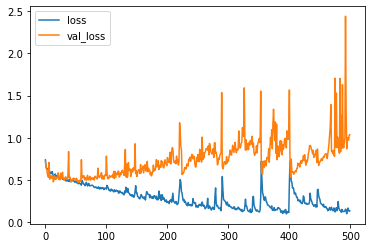

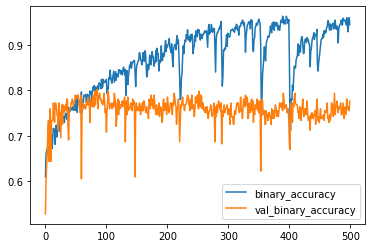

In [19]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

KeyError: 'accuracy'

In [25]:
predictions = model.predict(ds_train)

b =0
m = 0
u = 0
for element in predictions :
    if(element[0] > 0.95) :
        m +=1
    elif(element[0]< 0.05) :
        b +=1
    else :
        u +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - doutes: ", u, "\n - Total comp: ", b+u+m," vs ",len(predictions))

Prédictions ;
 - Malin(s):  359 
 - Bénins:  321 
 - doutes:  255 
 - Total comp:  935  vs  935


In [21]:
predictions = model.predict(ds_val)

b =0
m = 0
for element in predictions :
    if(element[0] > 0.5) :
        m +=1
    elif(element[0]< 0.5) :
        b +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - Total comp: ", b+m," vs ",len(predictions))

Prédictions ;
 - Malin(s):  113 
 - Bénins:  120 
 - Total comp:  233  vs  233


In [22]:
from sklearn.metrics import plot_confusion_matrix  

def predict_class_label_number(dataset):
    predictions =  model.predict(dataset)
    res = np.zeros(len(predictions))
    i = 0 
    for element in predictions : 
        if(element[0]> 0.5):
            res[i] = 1
        i += 1
    return tf.convert_to_tensor(res)

def give_labels (dataset, size):
    lab = np.zeros(size)
    i = 0
    for batch in dataset:
        for element in batch[1] :
            lab[i] = element.numpy()
            i +=1
    return tf.convert_to_tensor(lab)
    
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(5,5))
    plt.imshow(cm)
    plt.colorbar()
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

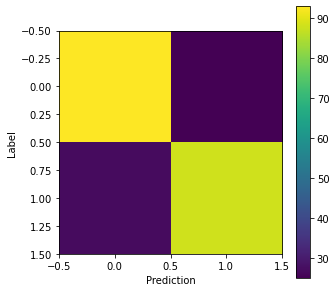

In [23]:
dataset = ds_val
confusion_mtx = tf.math.confusion_matrix(
    give_labels(dataset, size),
    predict_class_label_number(dataset),
    num_classes=2)
show_confusion_matrix(confusion_mtx, [0,1])